<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# Eletronics Purchase Prediction

Today you are a machine learning engineer in the Department of Marketing and Inventory at Walmart Labs. You have access to the Walmart server data, specifically the Electronics section. However, there is no customer facing information, but you do have access to timestamped data regarding product viewing/carting/purchasing. We will use this data to build a model of whether or not some product will be purchased.

Data is adapted from [e-commerce behavior data on Kaggle](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store). 

This file contains behavior data from a large multi-category store. Each row in the file represents an event. All events are related to products and users. Each event has a many-to-many relationship between users and products. 

## Learning Objectives

At the end of this session, you will be able to

- Leverage `pandas_profiling` for fast data understanding
- Practice data preprocessing
- Build logistic regression / SVM / Gradient Boosting
- Evaluate models with proper metrics
- Interpret black box models with SHAP
- Generate optimal pipeline for classification task using AutoML

## Task 1: Load data

In [6]:
#where am i
import os
os.getcwd()

'/Users/sushmitavijofficecomputer/assignment6/week-6-supervised-ML/nb'

In [8]:
%%sh
unzip archive.zip

Archive:  archive.zip
  inflating: 2019-Nov.csv            
  inflating: 2019-Oct.csv            


Let's start by looking at the descriptions before loading in the csv files.

1. Use the `IPython.display` module to view the `some_column_descriptions.png` file. Look through the column names and descriptions to get an idea of what the data is.

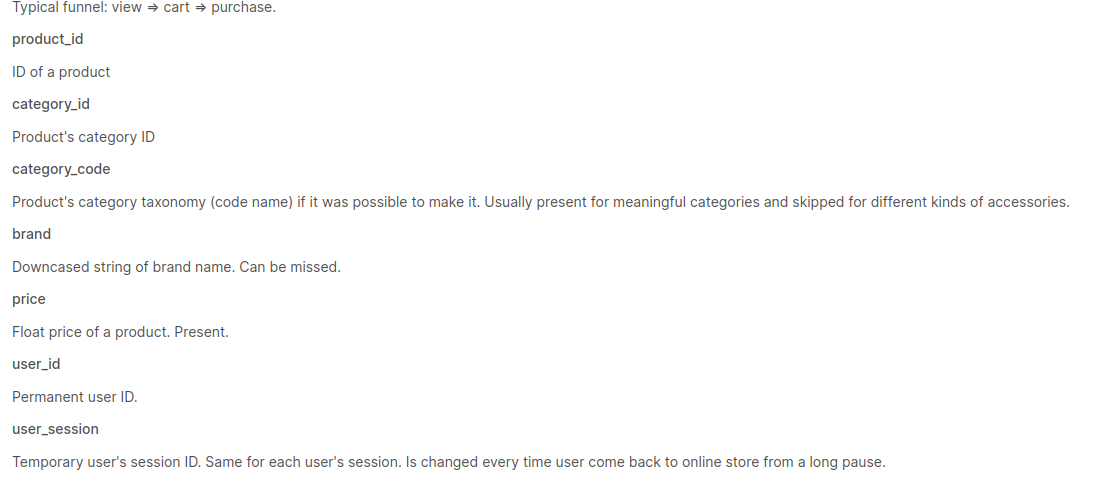

In [9]:
from IPython.display import Image, display
# change the filename to wherever you downloaded/uploaded the file
filename = '../img/some_column_descriptions.png'
display(Image(filename=filename))

The dataset has User-journey data, i.e., it tracks information on user/product pairs over time to see if the combination results in a purchase.

2. Look at the `user_journey_descriptions.png` file. Review the data sample to get a sense of what information we are tracking for each user/product pair.

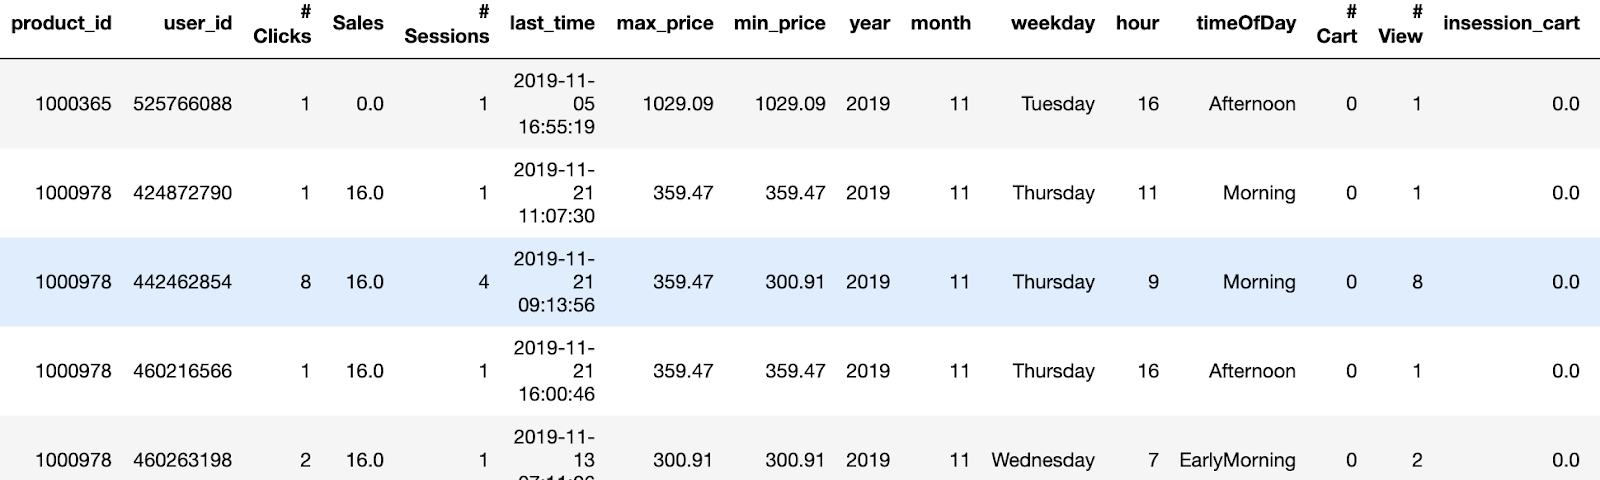

In [10]:
# change path to wherever you uploaded/downloaded the file
filename='../img/user_journey_descriptions.png'
display(Image(filename=filename))

The dataset we are working with is essentially what we have screenshotted above, but has been anonymized by removing product IDs and user IDs.

3. Use the pandas `read_csv()` and `head()` functions to read in the training data (`../dat/train.csv.gz`) and look at the first few rows.

    Note the `Purchase` column has values either 0 (not purchased) or 1 (purchased).

In [13]:
import pandas as pd
train_df = pd.read_csv('../dat/train.csv.gz') # YOUR CODE HERE

In [14]:
train_df.head() # YOUR CODE HERE

NumOfEventsInJourney  NumSessions  interactionTime  maxPrice  minPrice  \
0                     1            1              0.0    154.41    154.41   
1                     1            1              0.0     92.67     92.67   
2                     1            1              0.0    155.71    155.71   
3                     1            1              0.0    898.32    898.32   
4                     1            1              0.0    146.21    146.21   

   NumCart  NumView  InsessionCart  InsessionView  year  month weekday  \
0        0        1              0              1  2019     11     Sat   
1        0        1              0              1  2019     11      Fr   
2        0        1              0              1  2019     11     Thu   
3        0        1              0              1  2019     11     Mon   
4        0        1              0              1  2019     11     Tue   

   timeOfDay  Weekend  Purchase  
0    Morning        0         0  
1       Dawn        0         0  
2  Afternoon        0         0  
3       Noon        0         0  
4       Noon        0         0

4. What is the dimension of the training data?

In [16]:
train_df.shape

(645816, 15)

5. Similarly, read in the test data `../dat/test.csv.gz` and check its dimension.

In [45]:
test_df = pd.read_csv('../dat/test.csv.gz') # YOUR CODE HERE
test_df.shape

(430544, 15)

## Task 2: Understand data

Our goal here is to predict whether a customer/product pair will result in a purchase. 
To do this, we will want to identify the most important features for classification. 

Before digging into each column, let's leverage `pandas_profiling`, that goes beyond `pd.DataFrame.describe()`, to get a big picture of our data set. 

1. From `pandas_profiling` import `ProfileReport`. 
    
    For faster iteration, create a profile report object `profile` with 10,000 samples from `train_df`. 
    
    Set its `title` as "Pandas Profiling Electronics Purchase Report". 
    
    For sampling, use `pd.DataFrame.sample(10000, randome_state=3)`. 

   Show the report inside the notebook, go over the report and check each tab; especially the "Alerts". 

In [19]:
from pandas_profiling import ProfileReport

In [55]:
sample_train_df = train_df.sample(n=10000, random_state=3)

In [80]:
profile = ProfileReport(sample_train_df)

In [26]:
#crappy presentation; very difficult to use; see next step
%%time
profile.to_notebook_iframe()

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 1.23 s, sys: 37 ms, total: 1.27 s
Wall time: 1.3 s


In [81]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

2. Pandas profiling Profile reports that there are 5 numeric variables and 11 categorical variables. Let's print out the datatype of each feature (column) and understand how the profiler infers data type. 

In [39]:
sample_train_df.dtypes

NumOfEventsInJourney      int64
NumSessions               int64
interactionTime         float64
maxPrice                float64
minPrice                float64
NumCart                   int64
NumView                   int64
InsessionCart             int64
InsessionView             int64
year                      int64
month                     int64
weekday                  object
timeOfDay                object
Weekend                   int64
Purchase                  int64
dtype: object

3. From the report, we see that `year`, `month`, and `Weekend` were "Rejected" as there is only one distinct value for each column. 
These features are not informative, so we remove the three features from the training set. To do this, pass the `columns` argument to the `.drop()` method. 
Make sure to use `inplace=True` to modify the DataFrame. 
Print the shape of the DataFrames to verify the columns were dropped.

In [56]:
cols_to_drop = ['year', 'month', 'Weekend']
sample_train_df.drop(cols_to_drop, axis=1, inplace=True)
sample_train_df.shape

(10000, 12)

4. Repeat the steps for `test_df`:

In [46]:
test_df.drop(cols_to_drop, axis=1, inplace=True)
test_df.shape

(430544, 12)

5. As you can see from the profile report, `weekday` and `timeOfDay` each has 7 distinct values. 
Convert these non-numeric features to numeric. 

    These feature values are ordered temporally, so it makes sense to convert them to numeric type. 
    Follow the example given for the `weekday` column to update the `timeOfDay` column.
    Use the `.head()` method to inspect the dataset after the transformations.

In [57]:
weekday_str2num = {
    s: i+1 for i, s in enumerate(['Mon', 'Tue', 'Wed', 'Thu', 'Fr', 'Sat', 'Sun'])
}
sample_train_df['weekday'] = sample_train_df['weekday'].replace(weekday_str2num)
sample_train_df['weekday'].unique()

array([5, 4, 1, 7, 6, 2, 3])

In [58]:
timeOfDay_str2num = {
    s: i+1 for i, s in enumerate(['Dawn', 'EarlyMorning', 'Morning', 'Noon', 'Afternoon', 'Evening', 'Night'])
}
sample_train_df['timeOfDay'] = sample_train_df['timeOfDay'].replace(timeOfDay_str2num) # YOUR CODE HERE
sample_train_df['timeOfDay'].unique()

array([3, 4, 6, 1, 5, 2, 7])

6. Do the same for `test_df`, that is, to convert `weekday` and `timeOfDay` into numeric type. 

In [59]:
test_df['weekday'] = test_df['weekday'].replace(weekday_str2num) # YOUR CODE HERE
test_df['timeOfDay'] = test_df['timeOfDay'].replace(timeOfDay_str2num) # YOUR CODE HERE

7. Use the `Purchase` column in training set to determine the proportion of user journeys that result in purchases.  Compare it to what the profile reports. Is the dataset balanced?

In [67]:
print("number of purchases vs non-purchases in train set:")
print(train_df.Purchase.value_counts())
count_purchase = train_df.Purchase.value_counts()

number of purchases vs non-purchases in train set:
0    636839
1      8977
Name: Purchase, dtype: int64


In [93]:
num_purchase = train_df.loc[train_df.Purchase == 0, 'Purchase'].count()

percent = 100*(num_purchase)/(count_purchase.sum())

format_percent = "{:.2f}".format(percent)

In [94]:
print(f"percent of rows resulting in purchase: {format_percent}%") # YOUR CODE HERE

percent of rows resulting in purchase: 98.61%


## Task 3: Preprocess Data

Correlated features in general don't improve models (although it depends on the specifics of the problem like the number of variables and the degree of correlation), but they affect specific models in different ways and to varying extents:

- For linear models (e.g., linear regression or logistic regression), [multicolinearity](https://en.wikipedia.org/wiki/Multicollinearity) can yield [solutions that are wildly varying and possibly numerically unstable](https://en.wikipedia.org/wiki/Multicollinearity#Consequences).
- Random forest can be good at detecting interactions between different features, but highly correlated features can mask these interactions.
More generally, this can be viewed as a special case of [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor). A simpler model is preferable, and, in some sense, a model with fewer features is simpler. The concept of [minimum description length](https://en.wikipedia.org/wiki/Minimum_description_length) makes this more precise ([ref](https://datascience.stackexchange.com/questions/24452/in-supervised-learning-why-is-it-bad-to-have-correlated-features)).

1. How many features does our dataset currently have?

In [106]:
train_df.shape

(645816, 15)

2. Drop the features with high correlation.

    In the "Correlations" tab in the profile report, you can find heatmap using five different correlation metrics; toggle correlation desciptions if any one of them looks foreign to you.  

    We'll remove high correlated features by looking at each pair of features, and if they are highly correlated (at least 0.8), we won't include the second feature in the pair. Store the remaining set of features (the ones you didn't drop) in dataframes `train_df_reduced`. You are given most the code, make sure that you understand what each line does.
    
    First, calculate the correlation with just 10,000 samples.

In [96]:
train_small_df = train_df.copy().sample(n=int(1e4), random_state=12) 

In [101]:
#clean columns 
cols_to_drop = ['year', 'month', 'Weekend']
train_small_df.drop(cols_to_drop, axis=1, inplace=True)
train_small_df.shape

(10000, 12)

In [102]:
train_small_df['weekday'] = train_small_df['weekday'].replace(weekday_str2num)
train_small_df['timeOfDay'] = train_small_df['timeOfDay'].replace(timeOfDay_str2num)

In [103]:
cor = train_small_df.corr() # YOUR CODE HERE
print(cor)

                      NumOfEventsInJourney  NumSessions  interactionTime  \
NumOfEventsInJourney              1.000000     0.820386         0.502779   
NumSessions                       0.820386     1.000000         0.628841   
interactionTime                   0.502779     0.628841         1.000000   
maxPrice                          0.019786     0.020670         0.013432   
minPrice                          0.018034     0.018456         0.010612   
NumCart                           0.169965     0.145634         0.054007   
NumView                           0.562265     0.462171         0.316047   
InsessionCart                     0.142453     0.108800         0.039385   
InsessionView                     0.099629     0.028005         0.016925   
weekday                           0.023316     0.014853         0.000565   
timeOfDay                        -0.022551    -0.031422        -0.010380   
Purchase                          0.107172     0.074800         0.025312   

           

In [104]:
cor.shape

(12, 12)

In [107]:
import numpy as np

keep_columns = np.full(cor.shape[0], True)
for i in range(cor.shape[0] - 1):
    for j in range(i + 1, cor.shape[0] - 1):
        if (np.abs(cor.iloc[i, j]) >= 0.8):
            keep_columns[j] = False
selected_columns = train_small_df.columns[keep_columns]
train_df_reduced = train_small_df[selected_columns]

In [108]:
print(selected_columns) 

Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'weekday', 'timeOfDay', 'Purchase'],
      dtype='object')


3. How many columns are left in the DataFrame?

In [109]:
train_df_reduced.shape

(10000, 9)

In [110]:
train_df_reduced.columns

Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'weekday', 'timeOfDay', 'Purchase'],
      dtype='object')

4. Remove the same features from the test set and save in a new dataframe `test_df_reduced`.

In [112]:
test_df_reduced = test_df[selected_columns] # YOUR CODE HERE
test_df_reduced.shape[1]

9

5. Visualize the selected features and discuss your observations with your team.

    Again, for faster rendering, use the subset `train_small_df_reduced`. If time permits, experiment with some other visualizations of the data.

In [117]:
#names of the df are not referenced properly; I believe we are focusing on train_df_reduced which already has the selected columns done

import matplotlib.pyplot as plt
import seaborn as sns
train_small_df_reduced = train_df_reduced
fig = plt.figure(figsize=(12, 10))
j = 0
for i in train_df_reduced.columns:
    plt.subplot(3, 4, j + 1)
    j += 1
    sns.histplot(train_small_df_reduced[i][train_small_df_reduced['Purchase'] == 0], color='g', label='no')
    sns.histplot(train_small_df_reduced[i][train_small_df_reduced['Purchase'] == 1], color='r', label='yes')
    plt.legend(loc='best')
fig.suptitle('Subscription Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95);

6. Make the NumPy arrays `X_train_reduced`, `X_test_reduced`, `y_train` and `y_test` from `train_df_reduced` and `test_df_reduced`. 

In [114]:
y_train = train_df_reduced['Purchase'].values
y_test = test_df_reduced['Purchase'].values # YOUR CODE HERE
X_train_reduced = train_df_reduced.drop(columns='Purchase').values
X_test_reduced = test_df_reduced.drop(columns='Purchase').values # YOUR CODE HERE

7. Scale the features in `X_train_reduced` and `X_test_reduced` use `MinMaxScaler`

In [119]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # YOUR CODE HERE
X_train_reduced = scaler.fit_transform(X_train_reduced) # YOUR CODE HERE
X_test_reduced = scaler.fit_transform(X_test_reduced) # YOUR CODE HERE

In [121]:
X_train_reduced.shape

(10000, 8)

In [125]:
y_train.shape

(10000,)

## Task 4: Build Logistic Regression and SVM models

We will be fitting both a Logistic Regression and SVM model to the reduced features and then looking at classification metrics such as Accuracy, Precision, Recall, and F1-score.

In [134]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score as accuracy,
    recall_score as recall,
    precision_score as precision,
    f1_score
)

1. Instantiate, train, and predict using the Logistic Regression model.

    Make sure to account for the imbalanced classes with with `class_weight` parameter (what happens if we don't?).

    Remember to use the ***train*** data for training the model and the ***test*** data when making predictions.

In [130]:
%%time

lr_model = LogisticRegression()# YOUR CODE HERE
lr_fit = lr_model.fit(X_train_reduced, y_train)
lr_pred = lr_fit.predict(X_test_reduced) # YOUR CODE HERE

CPU times: user 120 ms, sys: 28.4 ms, total: 149 ms
Wall time: 28.3 ms


2. Calculate these classification metrics for the Logistic Regression model:

    * accuracy
    * precision
    * recall
    * f1 score
    * confusion matrix

In [131]:
print("accuracy:", accuracy(y_test, lr_pred))
print("precision:", precision(y_test, lr_pred))
print("recall:", recall(y_test, lr_pred))
print("f1 score:", f1_score(y_test, lr_pred))
print("confusion matrix:")
print(confusion_matrix(y_test, lr_pred))

accuracy: 0.9857900702367238
precision: 0.75
recall: 0.0004901960784313725
f1 score: 0.0009797517962116264
confusion matrix:
[[424423      1]
 [  6117      3]]


3. Instantiate, train and predict using the SVM model. Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) for usage. 

    Again, remember to account for the class imbalance.

In [136]:
%%time
svm_model = LinearSVC() # YOUR CODE HERE 
svm_model.fit(X_train_reduced, y_train)
svm_pred = svm_model.predict(X_test_reduced)

CPU times: user 67.8 ms, sys: 14.8 ms, total: 82.7 ms
Wall time: 46.8 ms


4. ❓ What is the time complexity of SVM? What is it for Logistic Regression? Not familiar with the term "time complexity"? Take a read on [Computational Complexity of ML Models
](https://medium.com/analytics-vidhya/time-complexity-of-ml-models-4ec39fad2770).

## TIME COMPLEXITY OF SVM IS LESS THAN LOGISTIC REGRESSION FOR CPU TIMES, I.E. NUMBER OF CYCLES THE CPU EXECUTED PER SECOND MEASURED IN GIGAHERTZ. HOWEVER, THE WALL TIME, I.E. THE ACTUAL WALL ON THE CLOCK TIME IS HIGHER. THIS IS BECASUE THE BIG O OF SVM, O(N-SQUARED), IS HIGHER THAN LOGISTIC REGRESSION, O(N*NUMBER OF FEATURES).

5. Calculate the classification metrics for the SVM model. 

Here you can use a helper function to display all the metrics. 

Inspect the source code to understand how to use the function. 

In [138]:
print("accuracy:", accuracy(y_test, svm_pred))
print("precision:", precision(y_test, svm_pred))
print("recall:", recall(y_test, svm_pred))
print("f1 score:", f1_score(y_test, svm_pred))
print("confusion matrix:")
print(confusion_matrix(y_test, svm_pred))

accuracy: 0.9561763722174738
precision: 0.24444711731216423
recall: 0.9962418300653595
f1 score: 0.3925696993110553
confusion matrix:
[[405579  18845]
 [    23   6097]]


In [ ]:
from utils import display_metrics
# YOUR CODE HERE

Wow, that's impressive! Why do you think SVM performs so well? If you are not familiar with Support Vector Machine, check [In-Depth: Support Vector Machines](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb) out for better understanding. 

## Task 5: Explanability with SHAP

Intepretation of a linear model such as logistic regression is staightforward, however, some tree-based models have a different reputation. In this task, we will fit a non-linear classifier: begin with gradient boosted tree, and use SHAP to help intepret the model. 

1. What are training coefficients from logistic regression? ( how about SVM? check [How does one interpret SVM feature weights?](https://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights) )

    Leave your comments on interpretation of this logistic regression model.
    
    ## Looks like the number of events, interaction time are positively influecing the prediction versus number of views, session views, and time of day is negatively influencing it. For example, as we get later in the day the chances of purchasing may go down. Especially true of the number of items in the cart (spontaneously added but balking at the total) and the number of views.

In [142]:
pd.options.display.float_format = '{:.2f}'.format

In [165]:
Features = ['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
    'NumView', 'InsessionView', 'weekday', 'timeOfDay']

In [143]:
lr_fit.coef_

array([[  6.65482198,   1.08841062,   0.27115849,  -4.18972505,
        -15.62464724,  -4.22966423,   0.33213814,  -0.78667491]])

In [146]:
#annoyingly refuses to suppress the scientific notation - how does one do that
svm_model.coef_

array([[ 6.30528241e+00,  2.49296034e-01,  1.42586855e-03,
        -3.50652576e+00, -8.44017761e+00, -1.78290240e+00,
         2.29628585e-03, -3.98957265e-03]])

2. Instantiate, train, and predict using the Gradient Boosted Trees model.

In [147]:
from sklearn.ensemble import GradientBoostingClassifier

In [148]:
%%time
gbt_model = GradientBoostingClassifier() # YOUR CODE HERE
gbt_model.fit(X_train_reduced, y_train)
gbt_pred = gbt_model.predict(X_test_reduced)

CPU times: user 904 ms, sys: 75.8 ms, total: 980 ms
Wall time: 1.05 s


3. Evaluate the model by calculating the classification metrics.

In [150]:
gbt_model.score(X_train_reduced, y_train)

1.0

In [152]:
confusion_matrix(y_test, gbt_pred)

array([[   965, 423459],
       [     2,   6118]])

In [154]:
from sklearn.metrics import classification_report
print(classification_report(y_test, gbt_pred,))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00    424424
           1       0.01      1.00      0.03      6120

    accuracy                           0.02    430544
   macro avg       0.51      0.50      0.02    430544
weighted avg       0.98      0.02      0.00    430544



4. SHAP (SHapley Additive exPlanations) is a game theory approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. You can use package [SHAP](https://github.com/slundberg/shap). 

    For this task, if you are not familar with the concept, read the book chapter [Interpretable Machine Learning - A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/shap.html) first. 

5. Consider experimenting on a smaller dataset. 

For example, start with a subset of 100 samples from the test data.

Once the script works properly, use all the data from `X_test_reduced`. 

Apply `shap.Explainer()` to calculate the SHAP values for the Gradient Boosting classifier you fit earlier.

In [155]:
X_test_reduced.shape[0]

430544

In [156]:
np.random.seed(123)
subset_size = 100 # start with 100
idx = np.random.randint(X_test_reduced.shape[0], size=subset_size)
X_test_reduced_subset = X_test_reduced[idx, ]

In [157]:
X_test_reduced_subset.shape #== (subset_size, 8)

(100, 8)

In [164]:
X_test_reduced_subset

array([[0.00000000e+00, 0.00000000e+00, 2.33016196e-02, 0.00000000e+00,
        9.09090909e-02, 1.47058824e-02, 0.00000000e+00, 1.66666667e-01],
       [0.00000000e+00, 0.00000000e+00, 4.18403540e-02, 0.00000000e+00,
        9.09090909e-02, 1.47058824e-02, 1.00000000e+00, 3.33333333e-01],
       [0.00000000e+00, 0.00000000e+00, 3.06984659e-02, 0.00000000e+00,
        9.09090909e-02, 1.47058824e-02, 3.33333333e-01, 1.66666667e-01],
       [0.00000000e+00, 0.00000000e+00, 1.99994561e-02, 0.00000000e+00,
        9.09090909e-02, 1.47058824e-02, 6.66666667e-01, 8.33333333e-01],
       [0.00000000e+00, 0.00000000e+00, 3.55736246e-01, 0.00000000e+00,
        9.09090909e-02, 1.47058824e-02, 5.00000000e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 7.33701881e-02, 5.88235294e-02,
        0.00000000e+00, 0.00000000e+00, 5.00000000e-01, 8.33333333e-01],
       [0.00000000e+00, 0.00000000e+00, 1.67983000e-02, 0.00000000e+00,
        9.09090909e-02, 2.94117647e-02, 6.66666667e-01, 8.

In [158]:
import shap
explainer = shap.Explainer(gbt_model)# YOUR CODE HERE

In [159]:
%%time
shap_values = explainer(X_test_reduced_subset) # YOUR CODE HERE

CPU times: user 10.1 ms, sys: 6.27 ms, total: 16.4 ms
Wall time: 24.8 ms


In [180]:
shap_values

.values =
array([[-6.73916795e-03, -1.66525103e-01, -1.10237604e-03, ...,
         3.56124830e-01, -5.59569209e-04,  0.00000000e+00],
       [-1.41939268e-02,  9.23147043e+00, -1.40208724e-02, ...,
         9.56825612e-01, -7.60197966e-03,  0.00000000e+00],
       [-6.31452838e-03, -1.66524755e-01, -1.10237604e-03, ...,
         3.56124830e-01, -9.83303593e-04,  0.00000000e+00],
       ...,
       [-9.97418608e-03, -1.52584461e-01,  6.87126019e-03, ...,
        -1.36496998e-02, -5.58872908e-04,  0.00000000e+00],
       [-9.54431177e-03,  1.00782528e+01, -1.40836554e-02, ...,
        -3.08185173e-02, -7.60213439e-03,  0.00000000e+00],
       [-6.31452838e-03, -1.66525071e-01, -1.10300782e-03, ...,
         3.56124830e-01, -9.83303593e-04,  0.00000000e+00]])

.base_values =
array([[-10.35407895],
       [-10.35407895],
       [-10.35407895],
       ...,
       [-10.35407895],
       [-10.35407895],
       [-10.35407895]])

.data =
array([[0.00000000e+00, 0.00000000e+00, 4.92838190e-02, .

6. visualize the effects over all samples using `shap.plots.beeswarm()` or `shap.summary_plot()`. 

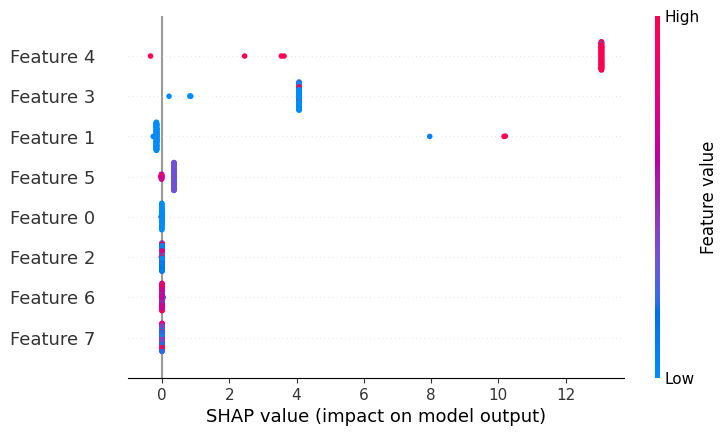

In [169]:
shap.plots.beeswarm(shap_values, max_display=20) #so annoying no feature labels

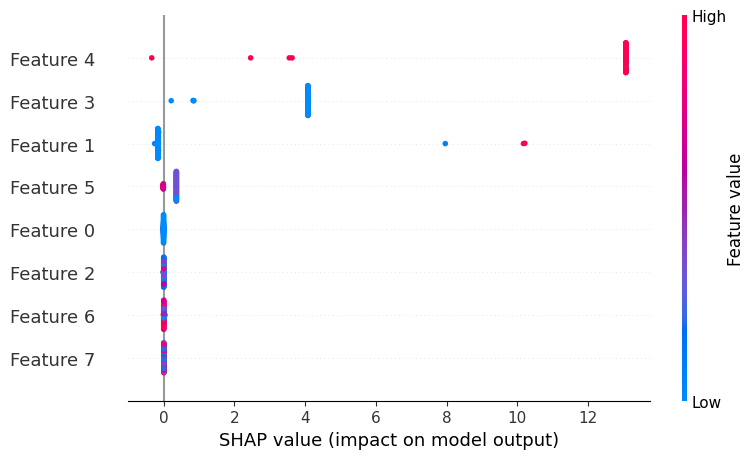

In [161]:
shap.summary_plot(shap_values) #so annoying - no feature labels

In [162]:
shap.plots.waterfall(shap_values[0])

Exception: waterfall_plot requires a scalar base_values of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.base_values[0], values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.base_values[0], values[0][0], X[0]).

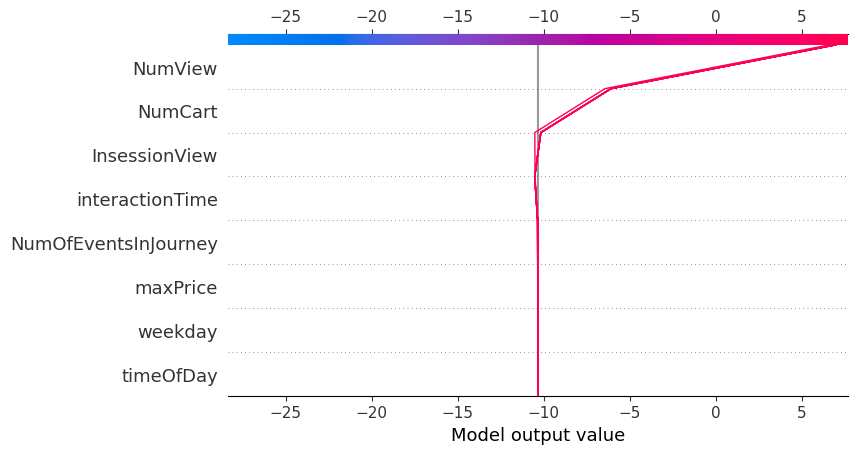

In [166]:
# Get expected value and shap values array
expected_value = explainer.expected_value
shap_array = explainer.shap_values(X_test_reduced_subset)

#Descion plot for first 10 observations
shap.decision_plot(expected_value, shap_array[0:10],feature_names=list(Features))

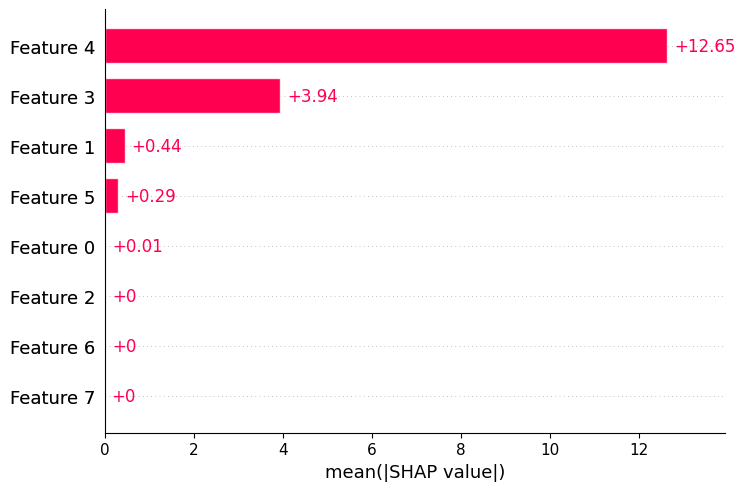

In [171]:
shap.plots.bar(shap_values)

7. What are features 4, 3, and 1? Does each feature positively or negatively contribute to the likelihood of purchase?

# Very hard to understand given no labels in the array. From the feature list before it looks like Number of Views (4), Number of Items in Cart (3), Interaction Time (1) is what we are talking about here as being important contributors to the prediction. Based on the beeswarm, when number of views are high, shap value is high (high positive contribution) therefore, this feature contributes positively to the likelihood of purchase. Harder to tell for the other two features, however, it looks like when they are lower valued, there is lower contribution to the prediction. Therefore they are positively correlated too. Atleast that's how the Gradient Boost model sees it.

In [172]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, Features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

8. Visualize the effects over all samples using `shap.plots.beeswarm()` or `shap.summary_plot()`. 

In [173]:
%%time
shap_values = explainer(X_test_reduced) # YOUR CODE HERE 
# YOUR CODE HERE

CPU times: user 24.8 s, sys: 135 ms, total: 24.9 s
Wall time: 25 s


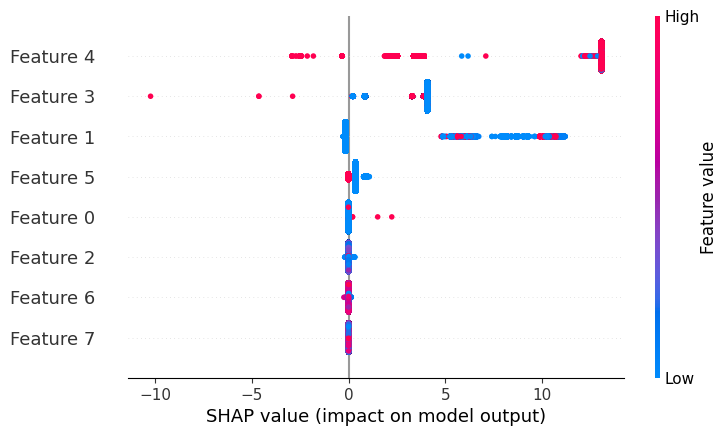

In [174]:
shap.plots.beeswarm(shap_values)

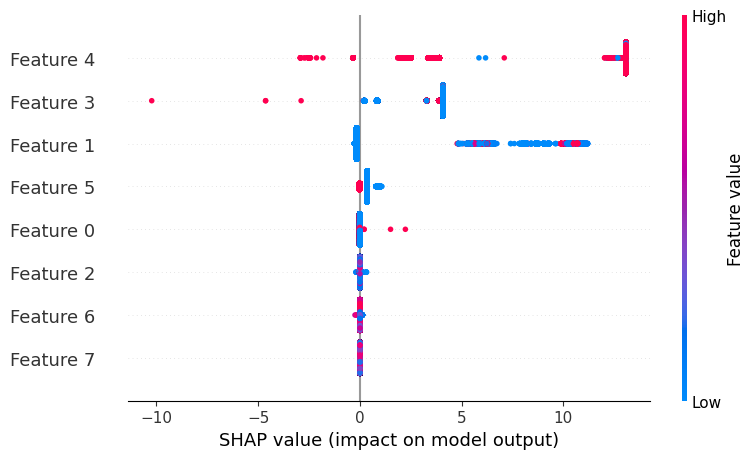

In [175]:
shap.summary_plot(shap_values)

9. Write your data (shap values) to a file and add them under the Model Explainability tab in the Streamlit app (see next section), following the example in Model Results tab.

In [178]:
pwd

'/Users/sushmitavijofficecomputer/assignment6/week-6-supervised-ML/nb'

In [184]:
svv = np.asarray(shap_values.values)
svv.tofile("shap_values.csv", sep = ',')

In [185]:
svd = np.asarray(shap_values.data)
svd.tofile("shap_data.csv", sep = ',')

In [186]:
svb = np.asarray(shap_values.base_values)
svd.tofile("shap_basevalues.csv", sep = ',')

10. Optional. Do the same for a random forest model.

## Task 6: AutoML

Let's see how AutoML performs on this imbalanced dataset. Similarly, for faster iteration on our workflow, experiment it on a small smaple. 

1. Take 5,000 samples from `train_df`, 5,000 from `test_df` for experimenting.

In [196]:
train_features = train_df.sample(int(5e3), random_state=42)
train_label = train_features.pop('Purchase')
test_features = test_df.sample(int(5e3), random_state=42)
test_label = test_features.pop('Purchase')

In [193]:
train_label.head()

623884    0
411741    0
8631      1
132868    0
42918     0
Name: Purchase, dtype: int64

In [208]:
train_label.columns = ['target']

In [209]:
print(train_label)

623884    0
411741    0
8631      1
132868    0
42918     0
         ..
96919     0
336533    1
595386    0
48008     0
572256    0
Name: Purchase, Length: 5000, dtype: int64


In [194]:
train_features.head()

NumOfEventsInJourney  NumSessions  interactionTime  maxPrice  \
623884                     1            1             0.00    180.16   
411741                     1            1             0.00     37.84   
8631                       1            1             0.00     95.24   
132868                     1            1             0.00    100.39   
42918                      1            1             0.00     62.81   

        minPrice  NumCart  NumView  InsessionCart  InsessionView  year  month  \
623884    180.16        0        1              0              1  2019     11   
411741     37.84        0        1              0              1  2019     11   
8631       95.24        0        0              0              0  2019     11   
132868    100.39        0        1              0              1  2019     11   
42918      62.81        0        1              0              1  2019     11   

        weekday  timeOfDay  Weekend  
623884        6       Dawn        0  
411741        3  Afternoon        0  
8631          3       Noon        0  
132868        5    Evening        0  
42918         2       Noon        0

2. Instantiate and train a TPOT auto-ML classifier.

    The parameters in the code below are set to low values for faster iterations. 
    Read about each parameters [here](http://epistasislab.github.io/tpot/api/#classification) and experiment with different values when time permits.
    
    Set a proper [`scoring` function](http://epistasislab.github.io/tpot/using/#scoring-functions). 

Scoring options in TPOT
	'accuracy', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy',
'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_median_absolute_error', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted',
'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'my_module.scorer_name*'

In [210]:
%%time

from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=10, 
                      population_size=16,
                      scoring="accuracy",# YOUR CODE HERE
                      verbosity=2,
                      random_state=42)
tpot.fit(train_features, train_label)
print(f"Tpop score on test data: {tpot.score(test_features, test_label):.2f}")
tpot.export('tpot_electronics_pipeline.py')

Optimization Progress:   0%|          | 0/176 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -inf


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.


ValueError: could not convert string to float: 'EarlyMorning'

3. Examine the model pipeline that TPOT classifier offers in the python file `tpot_electronics_pipeline.py` in the `nb` directory. 
If you see any model, function, or class that are not familiar, look them up!

    Note: There is randomness to the way the TPOT searches, so it's possible you won't have exactly the same result as your classmate.

In [190]:
!cat tpot_electronics_pipeline.py # A sample output

import numpy as np
import pandas as pd
from sklearn.decomposition import FastICA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=42)

# Average CV score on the training set was: 1.0
exported_pipeline = make_pipeline(
    FastICA(tol=0.30000000000000004),
    ExtraTreesClassifier(bootstrap=True, criterion="entropy", max_features=0.9000000000000001, min_samples_leaf=2, min_samples_split=5, n_estimators=100)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(export

4. Take the appropriate lines (e.g., updating path to data and the variable names) from `tpot_electronics_pipeline.py` to build a model on our training set and make predictions on the test set. 

    Choose approriate metrics to evaluate the prediction from TPOT. 
    
    Optional. Add this to Streamlit `models` in the next section.

In [212]:
training_features = train_df.drop('Purchase', axis=1)
testing_features = test_df.drop('Purchase', axis=1)
training_target = train_df['Purchase']
testing_target = test_df['Purchase']

tpot.fit(training_features, training_target)

print(f"Tpop score on test data: {tpot.score(testing_features, testing_target):.2f}")
tpot.export('tpot_electronics_pipeline_sush_vij.py')

Optimization Progress:   0%|          | 0/176 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -inf


The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.
The least populated class in y has only 1 members, which is less than n_splits=5.


ValueError: could not convert string to float: 'Evening'

## Advanced Visualizations with Streamlit and Plotly!
Let's visualize our results in a way that makes it easy to compare our models!  
[Streamlit](https://streamlit.io/) is a Python package that makes it easy to create bespoke, dynamic and interactive web apps for visualizations.  
Lightweight web apps like this are a great way to present results to stakeholders! 

First we need to build our results dataset to render in Streamlit.

In [200]:
from collections import defaultdict

results_data = defaultdict(list)

models = ["Logistic Regression", "SVM", "Gradient Boosting Classifier"]

for model, pred in zip(models, [lr_pred, svm_pred, gbt_pred]):
    confusion = confusion_matrix(y_test, pred)
    accuracy_ = accuracy(y_test, pred)
    recall_ = recall(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    results_data['model'].append(model)
    results_data['tn'].append(confusion[0][0])
    results_data['fp'].append(confusion[0][1])
    results_data['fn'].append(confusion[1][0])
    results_data['tp'].append(confusion[1][1])
    results_data['accuracy'].append(accuracy_)
    results_data['recall'].append(recall_)
    results_data['f1_score'].append(f1)
results_df = pd.DataFrame(results_data)
results_df

model      tn      fp    fn    tp  accuracy  recall  \
0           Logistic Regression  424423       1  6117     3      0.99    0.00   
1                           SVM  405579   18845    23  6097      0.96    1.00   
2  Gradient Boosting Classifier     965  423459     2  6118      0.02    1.00   

   f1_score  
0      0.00  
1      0.39  
2      0.03

In [211]:
# Write our results_df to CSV
results_df.to_csv("../dat/model_results.csv")

2. Then, we need to built Stremlit app. 
For today's assignment, we wrote the code for you.
However, understand the code in `electronics_purchase_predictions_stremlit.py` because you might need to write a Streamlit web app on your own for the future assignments. 

3. Once you inspected the code, you will need to start streamlit from CLI. 
Try looking up how to do this yourself.

HINT: this is a python file - maybe if you run it as a python file from the CLI, it will give you further instructions. 

Note - once you run the stremlit, the prompt will ask you to provide an email. 
You can leave the email blank. 

And you are done! 

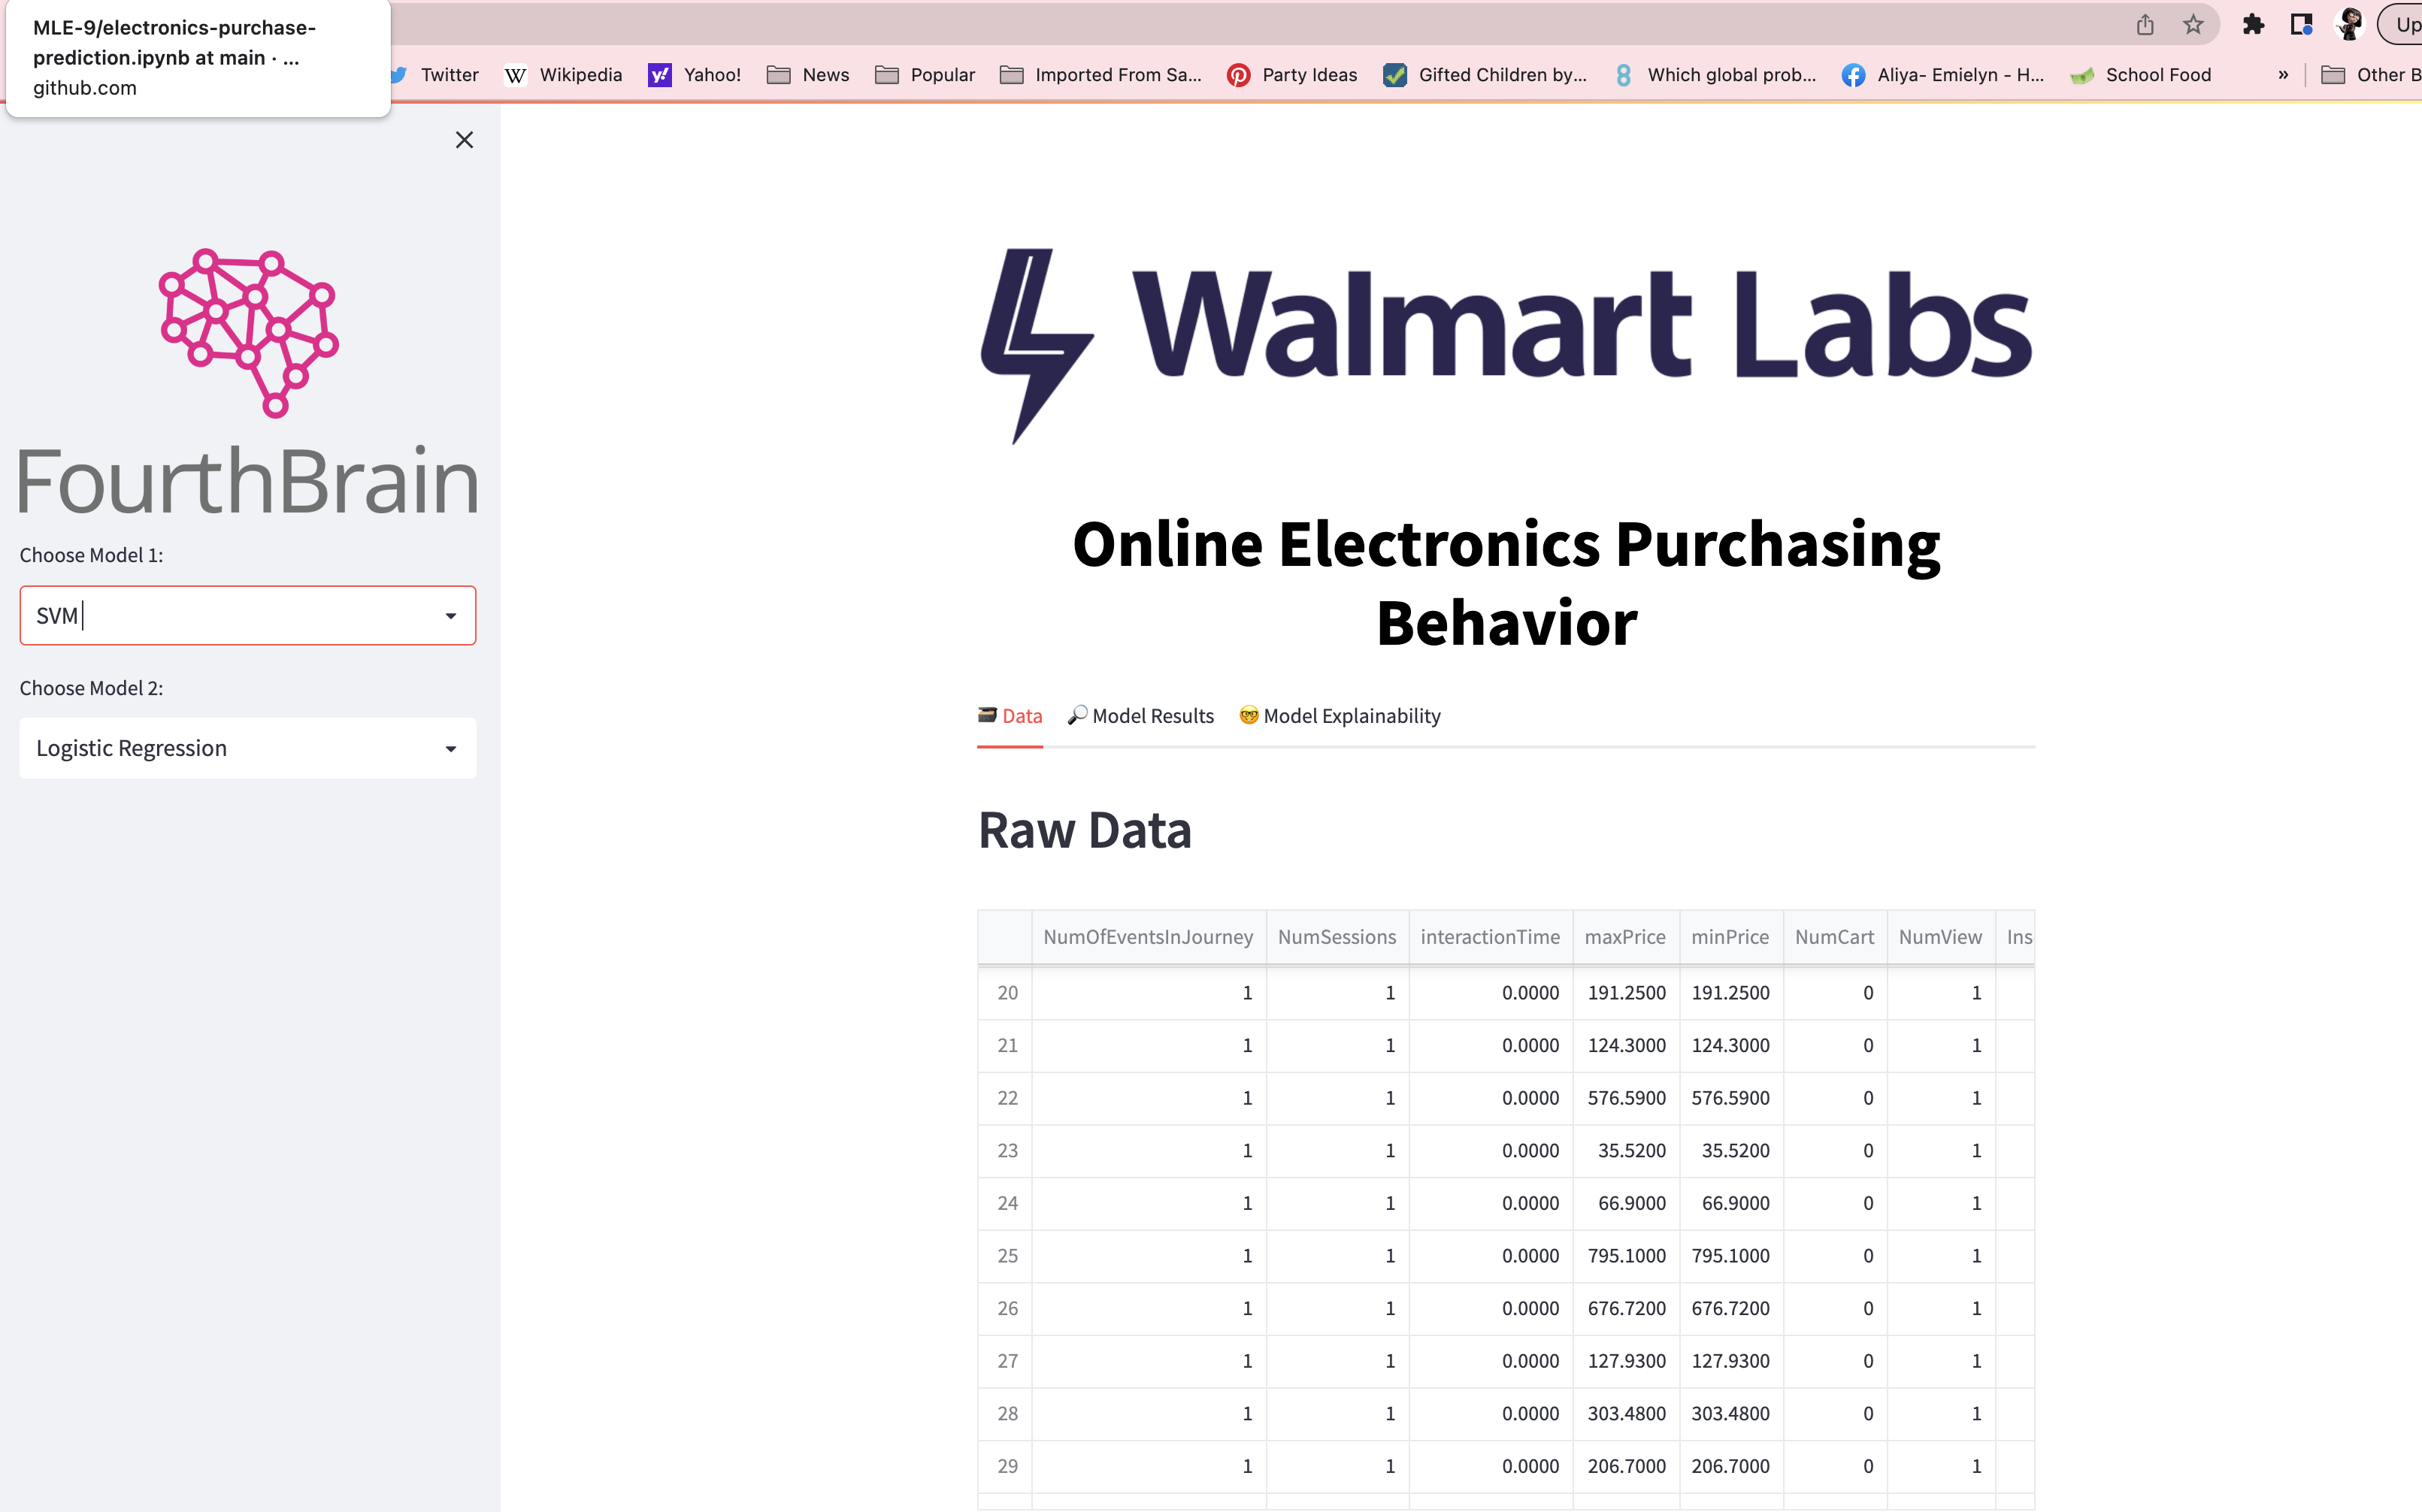

In [213]:
from IPython.display import Image
Image("Screen Shot 2022-10-04 at 12.34.08 PM.png")

## References

- This work is motivated by this [publication](https://arxiv.org/pdf/2010.02503.pdf) 
- [Comprehensive Guide on Feature Selection](https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection/notebook)
- [Common pitfalls and recommended practices](https://scikit-learn.org/stable/common_pitfalls.html)
- [Interactive Shapley Value Demonstration in Python](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/Interactive_Shapley_Values.ipynb)
- [Subsurface Data Analytics](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Feature_Ranking.ipynb)